# Plot NeverWorld2 setup

In [1]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import cmocean
import numpy as np

In [2]:
import xarray as xr
from dask.diagnostics import ProgressBar

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
run = 'nw2_0.125deg_N15_baseline_hmix20'
path = '/glade/p/univ/unyu0004/gmarques/NeverWorld2/baselines/'

In [5]:
chunks = {'time': 1}
st = xr.open_dataset('%s/%s/static.nc' % (path, run), decode_times=False)
av = xr.open_mfdataset('%s/%s/averages_*.nc' % (path, run), decode_times=False, chunks=chunks, combine='by_coords')

## Compute 500 day mean of $L_d / \sqrt{(\Delta x^2 + \Delta y^2)/2}$

In [6]:
av = av.isel(time=slice(-100, None))

In [7]:
av.Rd_dx

<xarray.DataArray 'Rd_dx' (time: 100, yh: 1120, xh: 480)>
dask.array<getitem, shape=(100, 1120, 480), dtype=float32, chunksize=(1, 1120, 480), chunktype=numpy.ndarray>
Coordinates:
  * xh       (xh) float64 0.0625 0.1875 0.3125 0.4375 ... 59.69 59.81 59.94
  * yh       (yh) float64 -69.94 -69.81 -69.69 -69.56 ... 69.69 69.81 69.94
  * time     (time) float64 5.502e+03 5.508e+03 ... 5.992e+03 5.998e+03
Attributes:
    long_name:      Ratio between deformation radius and grid spacing
    units:          m m-1
    cell_methods:   area:mean yh:mean xh:mean time: mean
    cell_measures:  area: area_t
    time_avg_info:  average_T1,average_T2,average_DT

More specifically, the MOM6 diagnostic `Rd_dx` is computed as
$$
{Rd}\_{dx} = \underbrace{\frac{c_1}{\sqrt{f^2 + 2 \beta c_1}}}_{L_d} \cdot \frac{1}{\sqrt{(\Delta x)^2 + (\Delta y)^2}} = L_d \cdot \frac{1}{\sqrt{(\Delta x)^2 + (\Delta y)^2}}
$$
see this [code snippet](https://github.com/mom-ocean/MOM6/blob/323ba0cb13197bc71ffb85fcb3521df2d4101dae/src/parameterizations/lateral/MOM_lateral_mixing_coeffs.F90#L258-L259) and [that one](https://github.com/mom-ocean/MOM6/blob/323ba0cb13197bc71ffb85fcb3521df2d4101dae/src/parameterizations/lateral/MOM_lateral_mixing_coeffs.F90#L1493-L1502).

In contrast, Hallberg (2013) uses the model's effective grid spacing $\tilde\Delta = \sqrt{(\Delta x)^2 + (\Delta y)^2/2}$, i.e., the looks at the diagnostic
$$
L_d \cdot \frac{1}{\sqrt{(\Delta x)^2 + (\Delta y)^2/2}}
$$
Here, we follow Hallberg (2013) and therefore modify the MOM6 diagnostic in the following.

In [8]:
Rd_dx_mod = av.Rd_dx * np.sqrt(2)  # modify diagnostic following Hallberg (2013)
Rd_dx_mod = Rd_dx_mod.mean(dim='time').compute()  # compute long term mean

## Plotting

In [9]:
params = {'legend.fontsize': 'large',
         'axes.labelsize': 'large',
         'axes.titlesize':'large',
         'xtick.labelsize':'large',
         'ytick.labelsize':'large',
         'font.size': 12}
pylab.rcParams.update(params)

In [10]:
extent = [0, 60, -70, 70]

In [11]:
# colormap for Rd/dx
from matplotlib import cm
nr_levels = 10
cmap = cm.get_cmap('PuRd', nr_levels)

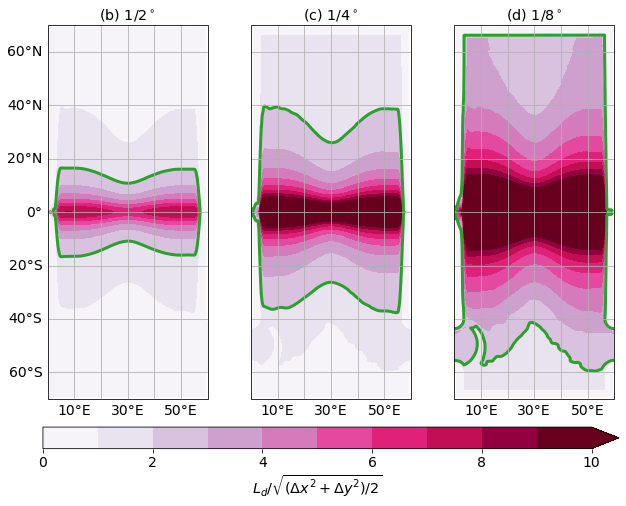

In [12]:
factor_list = [4, 2, 1]
label_list = [
    r'(b) 1/2$^\circ$', 
    r'(c) 1/4$^\circ$', 
    r'(d) 1/8$^\circ$'
]

fig, axs = plt.subplots(1,3,figsize=(10, 6),subplot_kw={'projection':ccrs.PlateCarree()})

for factor, lb, ax in zip(factor_list, label_list, axs.flatten()):
    p = (Rd_dx_mod / factor).plot(
        ax=ax, 
        add_colorbar=False,
        cmap=cmap,
        vmin=0, vmax=10,
        transform=ccrs.PlateCarree()
    ) 
    ax.contour(
        st.xh, st.yh, Rd_dx_mod / factor, levels = [2],
                 colors=('tab:green'), linestyles=('-',), linewidths=(3,)
    )
    ax.set(title = lb)
    ax.set_extent(extent, crs=ccrs.PlateCarree())
    gl = ax.gridlines(draw_labels=True)
    gl.top_labels = False
    gl.right_labels = False
    gl.xlabel_style = {'size': 14}
    gl.ylabel_style = {'size': 14}
    if factor < 4:
        gl.left_labels = False
        
# colorbar
fig.subplots_adjust(left=0.1, bottom=0.015)
cax = fig.add_axes([0.1, -0.1, 0.8, 0.05])
cb = fig.colorbar(p, cax=cax, extend='max', orientation='horizontal', label=r'$L_d / \sqrt{(\Delta x^2 + \Delta y^2)/2}$')
cb.ax.tick_params(labelsize=14)
figname = 'figures/setup2.png'
plt.savefig(figname, dpi=200, bbox_inches='tight', pad_inches=0)

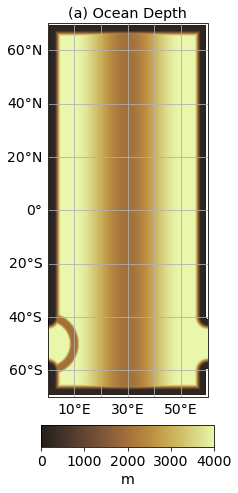

In [13]:
# Bathymetry
fig, ax1 = plt.subplots(1, 1, figsize=(3, 6),subplot_kw={'projection':ccrs.PlateCarree()})

p = st.depth_ocean.plot(
    ax=ax1,
    transform=ccrs.PlateCarree(),
    cmap=cmocean.cm.turbid_r,
    vmin=0, vmax=4000,
    add_colorbar=False
)
ax1.set(title='(a) Ocean Depth')
ax1.set_extent(extent, crs=ccrs.PlateCarree())
gl = ax1.gridlines(draw_labels=True)
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': 14}
gl.ylabel_style = {'size': 14}

# colorbar
fig.subplots_adjust(left=0.1, bottom=0.015)
cax = fig.add_axes([0.1, -0.1, 0.8, 0.05])
cb = fig.colorbar(p, cax=cax, orientation='horizontal', label=r'm')
cb.ax.tick_params(labelsize=14)


figname = 'figures/setup0.png'
plt.savefig(figname, dpi=200, bbox_inches='tight', pad_inches=0)